# Classifying album covers to genres
## Loading our images as a dataset
First, we are going to see how we can load our album cover images as a dataset. The goal is to be able to use these images like we used the MNIST dataset. We define a function that goes through the specified path, converts the images to arrays and then appends them to the array $X$. Also it appends the class of the index to the array $y$. Then we use the Scikit-learn function train_test_split to split $X$ and $y$ into $X_{train}$, $X_{test}$, $y_{train}$, $y_{test}$ and return these variables.

In [1]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

# define some useful constants
DATA_PATH = './data/covers_original/'
CATEGORIES = ['electronic', 'hiphop', 'jazz', 'pop', 'rock']
IMG_SIZE = 200
CATEGORIES_SIZE = 5
TRAIN_PERC = 0.8
TEST_PERC = 0.2

# define a function that creates the dataset
def load_data():
    X = []
    y = []
    # training data
    for category in CATEGORIES:
        path = os.path.join(DATA_PATH, category) # '../data/covers_original/<category>'
        cn = CATEGORIES.index(category) # get index of class name (e.g. 'electronic' => 0, 'rock' => 4)
        
        for img in os.listdir(path):
            try:
                img = load_img(os.path.join(path, img), target_size=(IMG_SIZE, IMG_SIZE))
                img_as_array = img_to_array(img)
                X.append(img_as_array)
                y.append(cn)
            except Exception as e:
                print(e)
    X = np.array(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_PERC)
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

# reshape and normalize the data
X_train = X_train.reshape((4000, IMG_SIZE, IMG_SIZE, 3))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((1000, IMG_SIZE, IMG_SIZE, 3))
X_test = X_test.astype('float32') / 255

# one-hot encode the class labels (0-9)
y_train = np_utils.to_categorical(y_train, CATEGORIES_SIZE)
y_test = np_utils.to_categorical(y_test, CATEGORIES_SIZE)


Using TensorFlow backend.
C:\Users\Chris\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Chris\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Chris\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Chris\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

[686, 3107, 1749, 3762, 3094, 228, 746, 1648, 3907, 957]
Image 686:


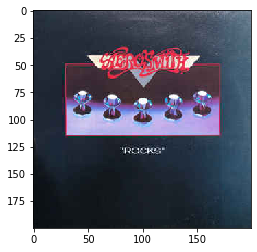

Class: [0. 0. 0. 0. 1.]
Image 3107:


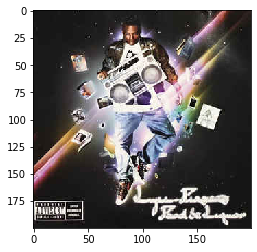

Class: [0. 1. 0. 0. 0.]
Image 1749:


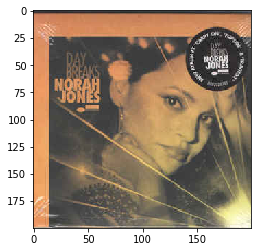

Class: [0. 0. 0. 1. 0.]
Image 3762:


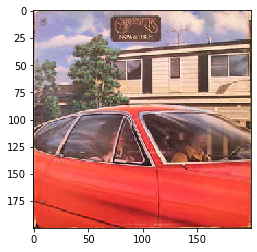

Class: [0. 0. 0. 1. 0.]
Image 3094:


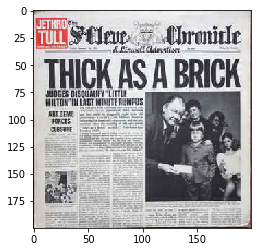

Class: [0. 0. 0. 0. 1.]
Image 228:


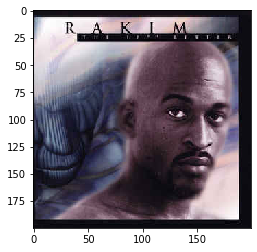

Class: [0. 1. 0. 0. 0.]
Image 746:


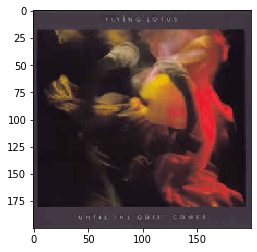

Class: [0. 0. 1. 0. 0.]
Image 1648:


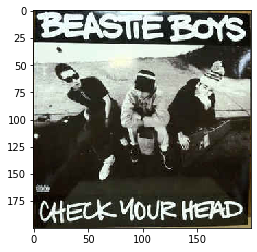

Class: [0. 1. 0. 0. 0.]
Image 3907:


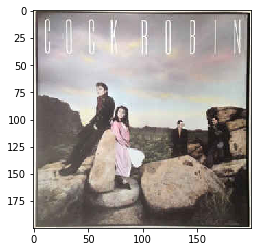

Class: [1. 0. 0. 0. 0.]
Image 957:


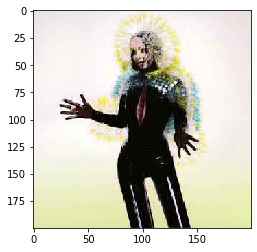

Class: [1. 0. 0. 0. 0.]


In [2]:
# to make sure that it actually works
permutation = random.sample(range(1, 4000), 10)
print(permutation)
for i in permutation:
    print('Image %d:' % i)
    img = array_to_img(X_train[i])
    plt.imshow(img)
    plt.show()
    print('Class:', y_train[i])

## The first model for our CNN.
Now we are going to describe our model for our CNN. We use the same model as we did when classifying the mnist digits. 

In [31]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu')) # reduced 1024 to 64 because of OOM Exceptions
model.add(Dense(5, activation='softmax'))
model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 200, 200, 32)      2432      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 100, 100, 64)      51264     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                10240064  
_________________________________________________________________
dense_12 (Dense)             (None, 5)                

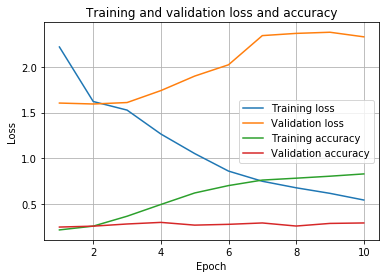

In [32]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss and accuracy')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

As we see above we only reach about $0.30$ ($30$%) accuracy. Maybe this is due to images belonging to more than one class (i.e. a cover may belong to both electronic and hiphop). Also we should reduce complexity, because it has ~$10.3$ million parameters to train.

## Try to increase accuracy
To increase accuracy, we may have to deal with covers belonging to more than one label. To do this, we change the activation function of our last layer to sigmoid instead of softmax. Also we are using binary crossentropy as a loss function instead of categorical crossentropy. To reduce complexity, we also reduced the number of filters for the layers.

In [30]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
# history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_test, y_test)) # das hier dürfte falsch sein, da validation und test data nicht die selben sein sollten
history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 200, 200, 32)      2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      25632     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2560032   
_________________________________________________________________
dense_10 (Dense)             (None, 5)                

As we can see, changing our activation function from softmax to sigmoid in our output layer, as well as using binary_crossentropy instead of categorical_crossentropy, helps to increase accuracy to about $76$% ($\lfloor0.763\rfloor$). But something still seems to be wrong, because our accuracy decreases from $80$% to ~$76$%. It seems that our model is overfitting.

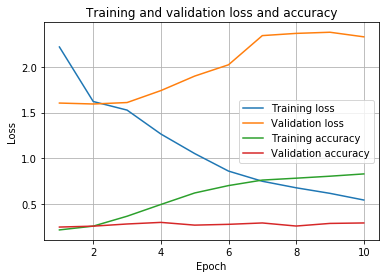

In [33]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss and accuracy')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Introducing Dropout
Now we will see how it performs when introducing Dropout to avoid overfitting.

In [34]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 200, 200, 32)      2432      
_________________________________________________________________
dropout_13 (Dropout)         (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 100, 100, 32)      25632     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 50, 50, 32)       

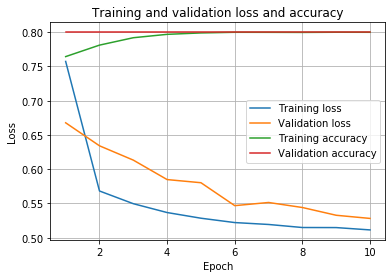

In [35]:
history_dict = history.history
train_loss = history_dict['loss']
train_acc = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss and accuracy')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Our validation accuracy does not drop anymore but is stuck at $80$%. Also training and validation loss are decreasing.

## Test how it classifies a single image after training
To test this, we will load a single image, reshape and normalize it and then use model.predict to get the class probabilities.

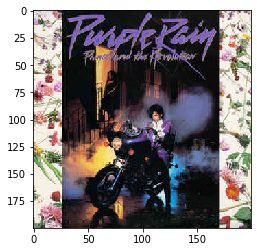

array([[0.30080575, 0.30246043, 0.27642626, 0.32335356, 0.30308697]],
      dtype=float32)

In [36]:
img = load_img('./data/covers_original/electronic/electronic.1.jpeg', target_size=(IMG_SIZE, IMG_SIZE))
img_as_array = img_to_array(img)
plt.imshow(img)
plt.show()
img_as_array = np.array(img_as_array)
img_as_array = img_as_array.reshape(1, IMG_SIZE, IMG_SIZE, 3)
img_as_array = img_as_array.astype('float32') / 255

model.predict(img_as_array)

## Loading our dataset with ImageDataGenerator class with data augmentation
Because we only have 5000 covers to use as our dataset, we are going to load our dataset using the ImageDataGenerator class applying data augmentation at the same time. Maybe this will help with reducing or avoiding overfitting.
First we are going to convert our original dataset to a format, that we can use with ImageDataGenerator.

In [37]:
import shutil
from random import shuffle

DATA_DEST = './data/covers'
VALIDATION_PERC = 0.2
TEST_PERC = 0.2

categories = os.listdir(DATA_PATH)

# unfortunately this is too slow, removing the directory 
# using finder or explorer is way faster
# remove directory if it already exists (for convenience)
# if os.path.exists(DATA_DEST):
#     shutil.rmtree(DATA_DEST)
        
for category in categories:
    # set up some paths
    oldCategoryPath = os.path.join(DATA_PATH, category)
    newCategoryTrainingPath = os.path.join(os.path.join(DATA_DEST, 'training'), category)
    newCategoryValidationPath = os.path.join(os.path.join(DATA_DEST, 'validation'), category)
    newCategoryTestPath = os.path.join(os.path.join(DATA_DEST, 'test'), category)

    # get all files of each category
    files = os.listdir(os.path.join(DATA_PATH, category))
    
    # make a directory for each category
    os.makedirs(newCategoryTrainingPath)
    os.makedirs(newCategoryValidationPath)
    os.makedirs(newCategoryTestPath)
    
    # for each category, see how far we have to run for training and validation images.
    training_end = int((1-(VALIDATION_PERC + TEST_PERC)) * len(files))
    validation_end = training_end + int(VALIDATION_PERC * len(files))
    test_end = validation_end + int(TEST_PERC * len(files))
    
    # separate training and validation files
    training_files = files[:training_end]
    validation_files = files[training_end:validation_end]
    test_files = files[validation_end:test_end]
    print('Training files:', len(training_files))
    print('Validation files:', len(validation_files))
    print('Test files:', len(test_files))
    
    # shuffle files
#     shuffle(training_files)
#     shuffle(validation_files)
    
    # copy training files to training path
    for idx, file in enumerate(training_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
#             newFilename = category + '_image_' + str(idx) + '.jpeg'
            newFilePath = os.path.join(newCategoryTrainingPath, file)
            shutil.copy(oldFilePath, newFilePath)

    # copy validation files to validation path
    for idx, file in enumerate(validation_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
#             newFilename = category + '_image_' + str(idx) + '.jpeg'
            newFilePath = os.path.join(newCategoryValidationPath, file)
            shutil.copy(oldFilePath, newFilePath)
    
    # copy validation files to test path
    for idx, file in enumerate(test_files):
        oldFilePath = os.path.join(oldCategoryPath, file)
        if file != '.DS_Store' and os.path.isfile(oldFilePath):
#             newFilename = category + '_image_' + str(idx) + '.jpeg'
            newFilePath = os.path.join(newCategoryTestPath, file)
            shutil.copy(oldFilePath, newFilePath)

Training files: 600
Validation files: 200
Test files: 200
Training files: 600
Validation files: 200
Test files: 200
Training files: 600
Validation files: 200
Test files: 200
Training files: 600
Validation files: 200
Test files: 200
Training files: 600
Validation files: 200
Test files: 200


In [43]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

BATCH_SIZE = 64
training_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = training_datagen.flow_from_directory(
    './data/covers/training',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

validation_gen = validation_datagen.flow_from_directory(
    './data/covers/validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

test_gen = test_datagen.flow_from_directory(
    './data/covers/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
)

# describe model architecture
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (5, 5), activation='relu', strides=(1,1), padding='same'))
model.add(Dropout(0.5))

model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='sigmoid'))
model.summary()

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# train model
history = model.fit_generator(
    train_gen,
    steps_per_epoch=3000 / BATCH_SIZE,
    validation_data=validation_gen,
    validation_steps=50,
    epochs=10
)

# compute loss and accuracy on test data
score = model.evaluate_generator(test_gen)
# score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Found 3000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 200, 200, 32)      2432      
_________________________________________________________________
dropout_25 (Dropout)         (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 100, 100, 32)      25632     
_________________________________________________________________
dropout_27 (Dropout)         (None, 100, 100, 32)      0    

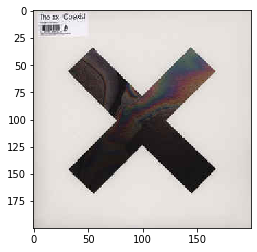

[[0.23957315 0.23778573 0.25118786 0.2480874  0.23479423]]


array([2], dtype=int64)

In [42]:
img = load_img('./data/covers/test/pop/pop.858.jpeg', target_size=(IMG_SIZE, IMG_SIZE))
img_as_array = img_to_array(img)
plt.imshow(img)
plt.show()
img_as_array = np.array(img_as_array)
img_as_array = img_as_array.reshape(1, IMG_SIZE, IMG_SIZE, 3)
img_as_array = img_as_array.astype('float32') / 255

print(model.predict(img_as_array))
model.predict_classes(img_as_array)

## Notiz
Evtl. wäre es sinnvoll eine CSV-Datei zu haben in denen die Labels und die Dateinamen drinstehen